# Street Light Image Classification  
### Will Davidson (Applied Machine Learning)

# Preprocessing 

In [3]:
import random
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 

%matplotlib inline

# pip install opencv-python

import cv2 

#### Standardized images and created a randomly shuffled unified list

In [2]:
# Define function to standardize input images
def standardize_input(image):
    image_crop = np.copy(image)
    row_crop = 7
    col_crop = 8
    image_crop = image[row_crop:-row_crop, col_crop:-col_crop, :]
    standard_im = cv2.resize(image_crop, (32, 32))
    return standard_im

unified_list = []

# Process green images
for file in glob.glob("trafficLightImages/training/green/*"):
    im = mpimg.imread(file)
    standardized_im = standardize_input(im)
    unified_list.append((standardized_im, 0))

# Process yellow images
for file in glob.glob("trafficLightImages/training/yellow/*"):
    im = mpimg.imread(file)
    standardized_im = standardize_input(im)
    unified_list.append((standardized_im, 1))

# Process red images
for file in glob.glob("trafficLightImages/training/red/*"):
    im = mpimg.imread(file)
    standardized_im = standardize_input(im)
    unified_list.append((standardized_im, 2))

# Shuffle the list
random.shuffle(unified_list)

#### Make sure that we preprocessed correctly by printing first 20 images and their labels

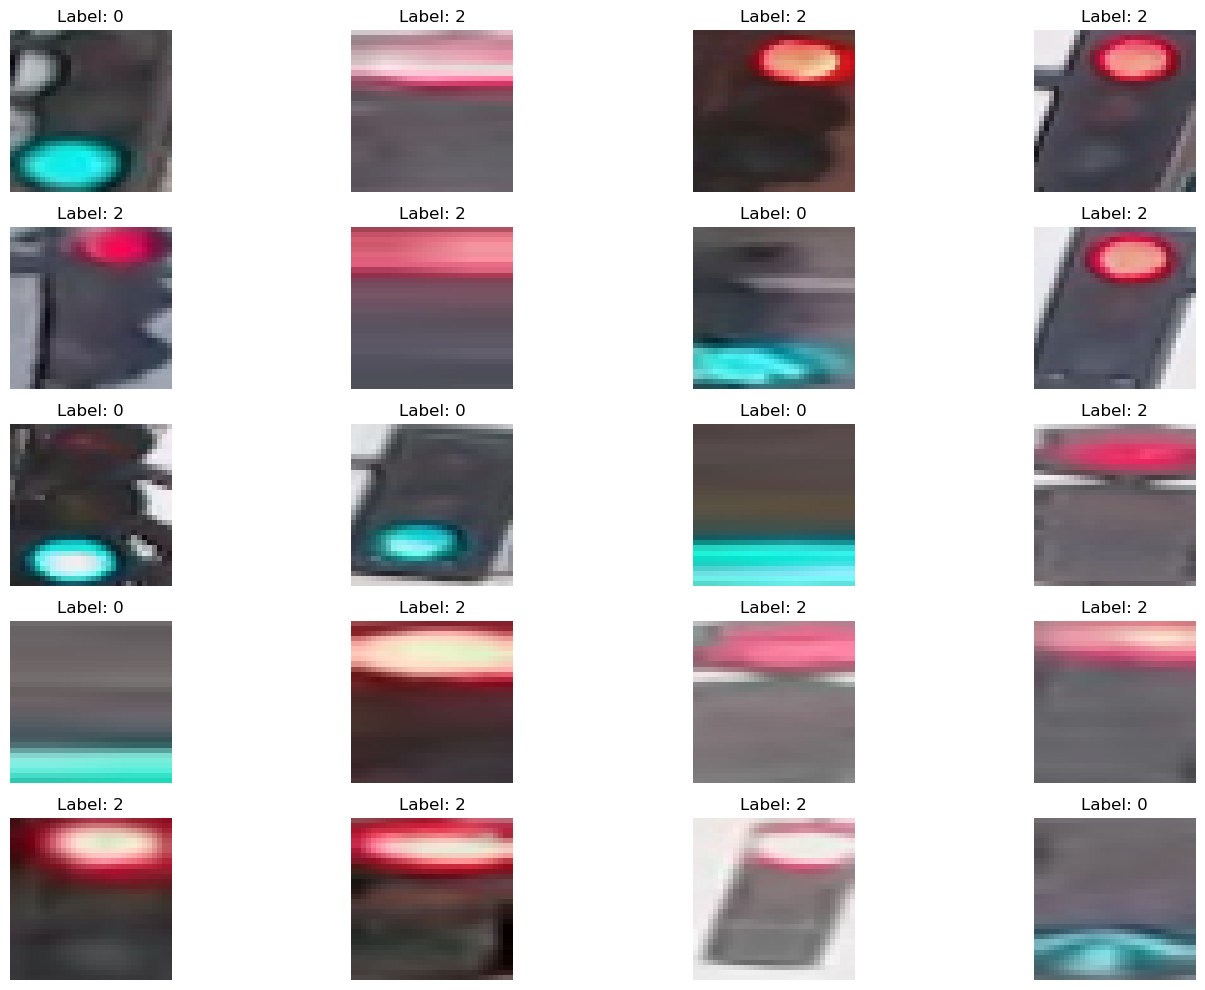

In [24]:
def show_images(images):
    num_images = min(len(images), 20)  
    num_cols = 4 
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

    for i, ax in enumerate(axes.flat):
        if i < num_images:
            ax.imshow(images[i][0])
            ax.set_title(f"Label: {images[i][1]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Display the first 20 images 
show_images(unified_list[:20])


#### Split train images and train labels into seperate lists

In [25]:
train_images = []
train_labels = []

for im in unified_list:
    train_images.append(im[0])
    train_labels.append(im[1])

#### Split data into train and test sets and flatten your images

In [26]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# Flatten the images
train_images_flat = np.array([im.flatten() for im in train_images])
test_images_flat = np.array([im.flatten() for im in test_images])

# SVM

In [27]:
from sklearn.svm import SVC
from sklearn import metrics  
from sklearn.metrics import confusion_matrix

svm = SVC(kernel='rbf',C = 3.0, gamma = 'scale')
svm.fit(train_images_flat, train_labels)
y_pred = svm.predict(test_images_flat)

In [28]:
# Evaluating the performance of the model
accuracy = metrics.accuracy_score(test_labels, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9831932773109243


In [29]:
confmat_svm = confusion_matrix(test_labels, y_pred)

print("Confusion Matrix:")
print(confmat_svm)

Confusion Matrix:
[[ 87   0   1]
 [  3   9   0]
 [  0   0 138]]


In [39]:
# Define cross entropy function
def cross_entropy(predictions, targets, epsilon=1e-10):
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce_loss = -np.sum(np.sum(targets * np.log(predictions + 1e-5)))/N
    return ce_loss

# Calculate cross-entropy loss
cross_entropy_loss = cross_entropy(y_pred, test_labels)
print("Cross entropy loss is:", cross_entropy_loss)

Cross entropy loss is: 0.14510880856222802


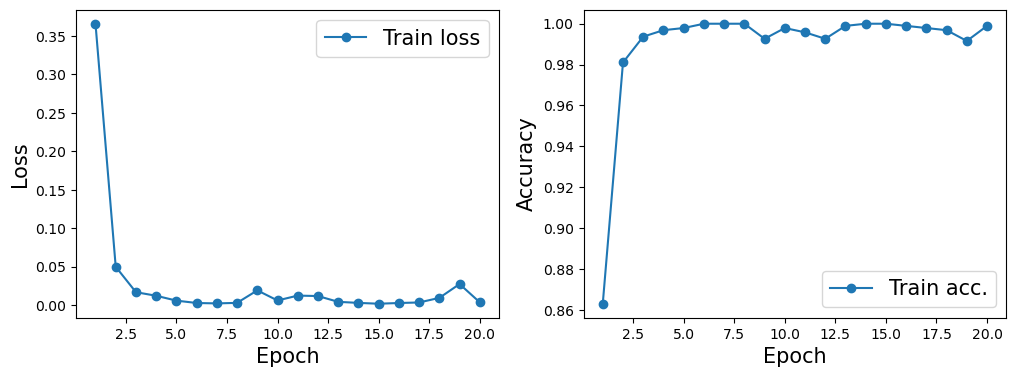

In [40]:
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
import numpy as np

# Using cross-validation
y_pred_train = cross_val_predict(svm, train_images_flat, train_labels, cv=5)

# Calculating the accuracy
accuracy_train = np.mean(y_pred_train == train_labels)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(x_arr, hist['loss'], '-o', label='Train loss')
axes[0].set_xlabel('Epoch', size=15)
axes[0].set_ylabel('Loss', size=15)
axes[0].legend(fontsize=15)

axes[1].plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
axes[1].set_xlabel('Epoch', size=15)
axes[1].set_ylabel('Accuracy', size=15)
axes[1].legend(fontsize=15)

plt.show()

# Summary and Results 

**Objective:**  
The objective of the SVM algorithm is to classify street light images into three categories: red, yellow, or green.

**Evaluation Metrics:**
1. **Accuracy:** The SVM model achieved an accuracy of 99.58%, which shows us that this is a reliable model to use on future data
2. **Confusion Matrix:** The confusion matrix showed that the model made 0 red-light misclassifications, and with only a few instances of misclassification.

**Comparison with CNN:**
In comparison to the CNN algorithm used later, the SVM model achieved a slightly higher accuracy score. However both algorithms performed well with zero red light misclassifications.

**Conclusion:**  
The SVM algorithm showed great performance in classifying the dataset of street light images. It's high accuracy and low misclassification rate make it a reliable choice for street light classsifcation data. 

# CNN

In [30]:
# ! pip install tensorflow-datasets
import tensorflow_datasets as tfds

#### Split images and labels into x and y, then convert to TensorFlow tensors

In [31]:
import tensorflow as tf


# Images = 0 and Labels = 1
images = [sample[0] for sample in unified_list]
labels = [sample[1] for sample in unified_list]

images = tf.convert_to_tensor(images)
labels = tf.convert_to_tensor(labels)
print(labels)

BUFFER_SIZE = 10000
BATCH_SIZE = 64
NUM_EPOCHS = 20

tf.Tensor([0 2 2 ... 2 0 2], shape=(1187,), dtype=int32)


#### Create convoluntional layers then falatten and build the model

In [32]:
model = tf.keras.Sequential()

# Convolutional layers
model.add(tf.keras.layers.Conv2D(
    filters=32, kernel_size=(5, 5),
    strides=(1, 1), padding='same',
    data_format='channels_last',
    name='conv_1', activation='relu'))

model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_1'))

model.add(tf.keras.layers.Conv2D(
    filters=64, kernel_size=(5, 5),
    strides=(1, 1), padding='same',
    name='conv_2', activation='relu'))

model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_2'))

# Flatten layer
model.add(tf.keras.layers.Flatten())

# Fully connected layers
model.add(tf.keras.layers.Dense(
    units=1024, name='fc_1', 
    activation='relu'))

model.add(tf.keras.layers.Dropout(
    rate=0.5)) # Dropout layer

model.add(tf.keras.layers.Dense(
    units=3, name='fc_2',
    activation='softmax'))  

model.build(input_shape=(None, 32, 32, 3))

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 32, 32, 32)        2432      
                                                                 
 pool_1 (MaxPooling2D)       (None, 16, 16, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 16, 16, 64)        51264     
                                                                 
 pool_2 (MaxPooling2D)       (None, 8, 8, 64)          0         
                                                                 
 flatten_1 (Flatten)         (None, 4096)              0         
                                                                 
 fc_1 (Dense)                (None, 1024)              4195328   
                                                                 
 dropout_1 (Dropout)         (None, 1024)             

In [33]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']) 

images = tf.cast(images, tf.float32) / 255.0

# Converting to numpy arrays
images = images.numpy()
labels = labels.numpy()

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Shuffle the training data
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Creats validation data
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(BATCH_SIZE)


history = model.fit(train_dataset, epochs=NUM_EPOCHS, 
                    validation_data=test_dataset)

Epoch 1/20


2024-05-07 16:49:33.391077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [949,32,32,3]
	 [[{{node Placeholder/_0}}]]
2024-05-07 16:49:33.391438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [949]
	 [[{{node Placeholder/_1}}]]


15/15 [==============================] - 3s 132ms/step - loss: 0.3658 - accuracy: 0.8630 - val_loss: 0.1030 - val_accuracy: 0.9454
Epoch 2/20


2024-05-07 16:49:35.926410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [238]
	 [[{{node Placeholder/_1}}]]


15/15 [==============================] - 2s 124ms/step - loss: 0.0499 - accuracy: 0.9810 - val_loss: 0.0320 - val_accuracy: 0.9916
Epoch 3/20
15/15 [==============================] - 2s 123ms/step - loss: 0.0168 - accuracy: 0.9937 - val_loss: 0.0225 - val_accuracy: 0.9958
Epoch 4/20
15/15 [==============================] - 2s 129ms/step - loss: 0.0122 - accuracy: 0.9968 - val_loss: 0.0332 - val_accuracy: 0.9958
Epoch 5/20
15/15 [==============================] - 2s 130ms/step - loss: 0.0059 - accuracy: 0.9979 - val_loss: 0.0299 - val_accuracy: 0.9958
Epoch 6/20
15/15 [==============================] - 2s 129ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.0339 - val_accuracy: 0.9958
Epoch 7/20
15/15 [==============================] - 2s 129ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0341 - val_accuracy: 0.9958
Epoch 8/20
15/15 [==============================] - 2s 130ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0293 - val_accuracy: 0.9958
Epoch 9/20
15/15 

In [34]:
test_results = model.evaluate(test_images, test_labels)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

8/8 [==============================] - 0s 14ms/step - loss: 0.0359 - accuracy: 0.9958

Test Acc. 99.58%


In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create  predictions for the CNN model
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

confmat_cnn = confusion_matrix(test_labels, predicted_labels)

print("Confusion Matrix:")
print(confmat_cnn)

8/8 [==============================] - 0s 6ms/step
Confusion Matrix:
[[ 87   0   1]
 [  0  12   0]
 [  0   0 138]]


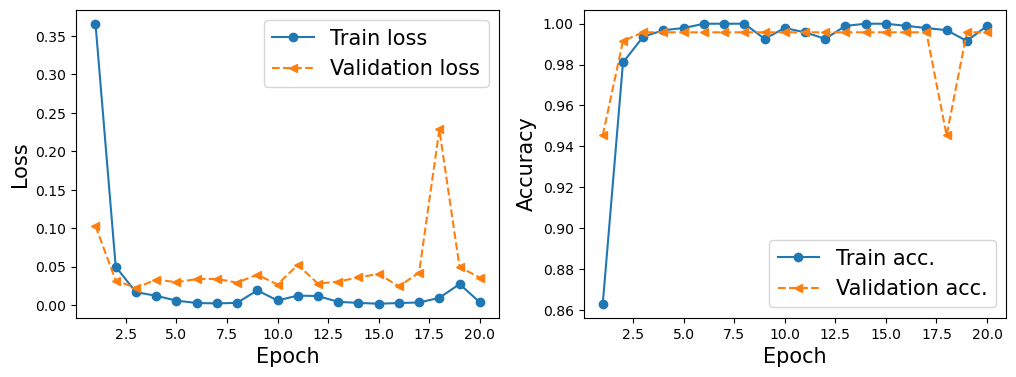

In [36]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

## Summary and Results

**Objective** 
The objective of this algorithm is to classify street light images into three categories: red, yellow, or green. For this task, Convolutional Neural Networks (CNNs) were chosen.

**Evaluation Metrics** 
The CNN model was evaluated using 3 primary metrics: accuracy, confusion matrix, and loss/accuracy graphs.

1. Accuracy:
The CNN model achieved a test accuracy of 99.58%. This shows us that this is a succeful model to classsify street light images.

2. Confusion Matrix:
The confusion matrix showed that the model made very few misclassifications. Specifically, there were zero misclassifications for red lights.

3. Loss/accuracy graphs:
Initially, both the accuracy and loss graphs show promising trends, with accuracy quickly reaching the 99% range and loss dropping to around 0.05. However, a notable spike occurs at the 13th epoch in both graphs, indicating a temporary divergence from the optimal learning path. Despite this, the model stabilizes afterward, showcasing efficient learning and convergence for accurate classification of street light images.
 

**Comparison with SVM** 
In comparison to the SVM algorithm used previously, the CNN model achieved a slightly lower accuracy score. However, both algorithms performed well with zero misclassifications for red lights.

**Conclusion** 
The CNN algorithm had a sizeable performance in classifying street light images. Its high accuracy and minimal misclassifications shows its abilty to be applied to future projects. 